In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
df = pd.read_csv("bank_notes.csv")
TARGET = "Target"
df

,variance,skewness,curtosis,entropy,Target
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
df.isna().sum().sum() + df.isnull().sum().sum()

0

In [4]:
df.duplicated().sum()

24

In [5]:
def get_X_y(df):
    return df.drop(columns=[TARGET]), df[TARGET]

In [6]:
def preprocess(df):
    df = df.copy(deep=True)

    # Dropping duplicates that we checked for
    df.drop_duplicates(inplace=True)
    
    # Normalization
    X, y = get_X_y(df)
    df = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)
    df[TARGET] = y

    return df

def pca_transform_df(df, pca: PCA):
    df = df.copy(deep=True)

    X, y = get_X_y(df)
    transformed_X = pca.transform(X)

    df = pd.DataFrame(transformed_X, columns=["PC1", "PC2"], index=X.index)
    df[TARGET] = y

    return df

In [7]:
df = preprocess(df)
pca = PCA(n_components=2, random_state=42).fit(get_X_y(df)[0])
df = pca_transform_df(df, pca)

In [8]:
X, y = get_X_y(df)
NO_OF_CLUSTERS = len(y.unique())

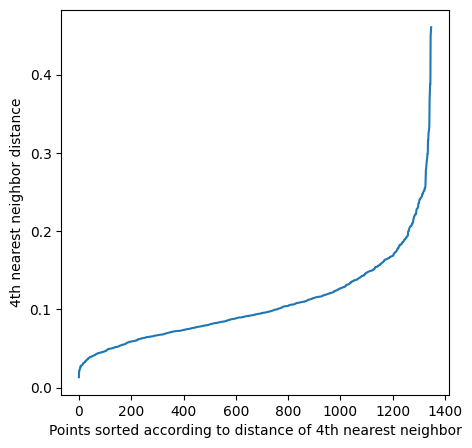

In [9]:
MIN_PTS = 2 * NO_OF_CLUSTERS

nearest_neighbors = NearestNeighbors(n_neighbors=MIN_PTS)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

distances = np.sort(distances[:, MIN_PTS-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points sorted according to distance of "+str(MIN_PTS)+"th nearest neighbor")
plt.ylabel(str(MIN_PTS)+"th nearest neighbor distance")
plt.show()

In [10]:
dbscan = DBSCAN(min_samples=MIN_PTS, eps=0.2)
y_pred = dbscan.fit(X)

labels = y_pred.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 10
Estimated number of noise points: 39


In [11]:

print(f"Homogeneity: {metrics.homogeneity_score(y, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(y, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(y, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(y, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Homogeneity: 0.109
Completeness: 0.113
V-measure: 0.111
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.106
Silhouette Coefficient: -0.078


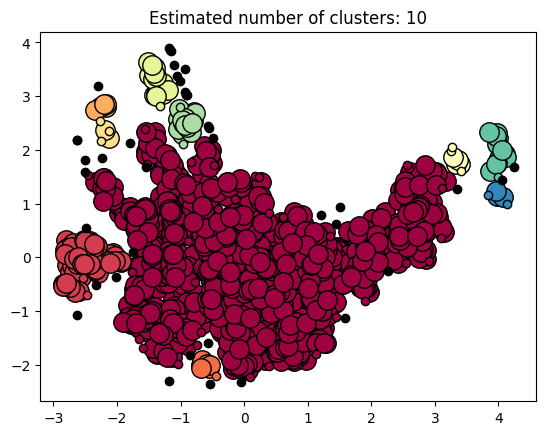

In [12]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()